## GPU Isochrones

### Load Libraries

In [1]:
import cudf
import cugraph
import cuspatial
from descartes import PolygonPatch
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
import pandas as pd
from shapely.geometry import Point, LineString, Polygon
from IPython.display import IFrame


ox.config(log_console=True, use_cache=True)

### Pull down Open Street Maps graph from Overpass API

In [2]:
def create_graph(loc, dist, transport_mode, loc_type='address'):
    # Transport mode = ‘walk’, ‘bike’, ‘drive’, ‘drive_service’, ‘all’, ‘all_private’, ‘none’
    if loc_type == "address":
        G = ox.graph_from_address(loc, dist=dist, network_type=transport_mode)
    elif loc_type == "points":
        G = ox.graph_from_point(loc, dist=dist, network_type=transport_mode )
    return G

In [3]:
%%time

# Place you are interested
place = '323 East 1st Avenue, Columbus, OH 43125'

# Transportation mode
mode = 'drive'  # options are 'walk', 'drive'

# Create network graph from place and mode
# G = create_graph(place, dist=150, transport_mode=mode, loc_type='address')
# G = create_graph(place, dist=250, transport_mode=mode, loc_type='address')
# G = create_graph(place, dist=500, transport_mode=mode, loc_type='address')
# G = create_graph(place, dist=5000, transport_mode=mode, loc_type='address')
# G = create_graph(place, dist=25000, transport_mode=mode, loc_type='address')
G = create_graph(place, dist=40000, transport_mode=mode, loc_type='address')

CPU times: user 3min 17s, sys: 1.56 s, total: 3min 19s
Wall time: 4min 39s


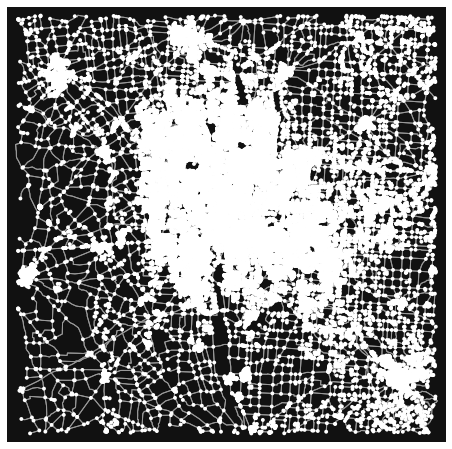

<Figure size 432x288 with 0 Axes>

CPU times: user 46.9 s, sys: 2.91 s, total: 49.8 s
Wall time: 45 s


In [4]:
%%time

fig, ax = ox.plot_graph(G, save=True);
plt.tight_layout()
#plt.savefig("graph.png")
plt.show()

In [5]:
# %%time

# graph_map = ox.plot_graph_folium(coordinates, popup_attribute='name', edge_width=2)
# # save as html file then display map as an iframe
# filepath = 'coordinates.html'
# graph_map.save(filepath)
# IFrame(filepath, width=900, height=500)

### Write graph, read graph in with cuDF and convert to cuGraph

In [6]:
%%time

# average driving speed in km/hour
travel_speed = 35
meters_per_minute = travel_speed * 1000 / 60 # km per hour to m per minute

edgelist = []
for i, j, data in G.edges(data=True):
    element = {}
    element['src'] = i
    element['dst'] = j
    # element['osmid'] = data['osmid']
    element['length'] = data['length']
    element['time'] = data['length'] / meters_per_minute
    edgelist.append(element)

CPU times: user 350 ms, sys: 72 µs, total: 350 ms
Wall time: 350 ms


In [7]:
%%time

edgelist_df = pd.DataFrame(edgelist)
print(edgelist_df.head())

        src        dst    length       time
0  33154031   33154064  8316.379  14.256650
1  33154064   33154066   785.422   1.346438
2  33154064  319738006   449.368   0.770345
3  33154066  319736886  2885.914   4.947281
4  33154078  319743510  5666.578   9.714134
CPU times: user 389 ms, sys: 7.86 ms, total: 397 ms
Wall time: 395 ms


In [8]:
%%time

gdf = cudf.DataFrame(edgelist_df)
print(gdf.head())

        src        dst    length       time
0  33154031   33154064  8316.379  14.256650
1  33154064   33154066   785.422   1.346438
2  33154064  319738006   449.368   0.770345
3  33154066  319736886  2885.914   4.947281
4  33154078  319743510  5666.578   9.714134
CPU times: user 1.09 s, sys: 423 ms, total: 1.51 s
Wall time: 1.54 s


In [9]:
%%time

# create a Graph using the source (src) and destination (dst) vertex pairs from the Dataframe 
G_gpu = cugraph.Graph()
# G_gpu.from_cudf_edgelist(gdf, source='src', destination='dst')
# G_gpu.from_cudf_edgelist(gdf, source='src', destination='dst', renumber=False)
G_gpu.from_cudf_edgelist(gdf, source='src', destination='dst', edge_attr='time')

CPU times: user 71.7 ms, sys: 12.1 ms, total: 83.8 ms
Wall time: 87.1 ms


In [10]:
# print(G_gpu.edges())
# print(G_gpu.nodes())

## Create Isochrones from Network Graphs

In [11]:
%%time

# Create nodes geodataframe from Graph network (G)
gdf_nodes = ox.graph_to_gdfs(G, nodes=True, edges=False, node_geometry=True, fill_edge_geometry=True)

CPU times: user 1.51 s, sys: 79 µs, total: 1.51 s
Wall time: 1.51 s


In [12]:
print(type(gdf_nodes))
print(gdf_nodes)

<class 'geopandas.geodataframe.GeoDataFrame'>
                    y          x       osmid            highway  ref  \
33154031    39.665993 -82.566110    33154031                NaN  NaN   
33154064    39.684365 -82.656490    33154064  motorway_junction  NaN   
33154066    39.690382 -82.661296    33154066                NaN  NaN   
33154078    39.721365 -82.676188    33154078                NaN  NaN   
33154172    39.858459 -82.828306    33154172                NaN  NaN   
...               ...        ...         ...                ...  ...   
8069410802  40.171518 -83.014099  8069410802                NaN  NaN   
8069725265  40.186387 -83.029509  8069725265                NaN  NaN   
8069725266  40.187594 -83.027257  8069725266                NaN  NaN   
8069725277  40.185998 -83.028757  8069725277     turning_circle  NaN   
8076599649  40.006995 -83.045082  8076599649                NaN  NaN   

                              geometry  
33154031    POINT (-82.56611 39.66599)  
3315406

In [13]:
%%time

gdf_nodes_gdf = cudf.DataFrame(gdf_nodes[['y', 'x', 'osmid']].reset_index().drop('index', axis=1))

CPU times: user 9.75 ms, sys: 56 µs, total: 9.8 ms
Wall time: 8.47 ms


In [14]:
print(gdf_nodes_gdf)

               y          x       osmid
0      39.665993 -82.566110    33154031
1      39.684365 -82.656490    33154064
2      39.690382 -82.661296    33154066
3      39.721365 -82.676188    33154078
4      39.858459 -82.828306    33154172
...          ...        ...         ...
63179  40.171518 -83.014099  8069410802
63180  40.186387 -83.029509  8069725265
63181  40.187594 -83.027257  8069725266
63182  40.185998 -83.028757  8069725277
63183  40.006995 -83.045082  8076599649

[63184 rows x 3 columns]


In [15]:
def get_nearest_node(gdf, point):
    gdf_nodes_gdf['point_y'] = point[0]
    gdf_nodes_gdf['point_x'] = point[1]
    gdf_nodes_gdf['distance'] = cuspatial.haversine_distance(gdf_nodes_gdf['y'], gdf_nodes_gdf['x'], 
                                                             gdf_nodes_gdf['point_y'], gdf_nodes_gdf['point_x'])
    mask = gdf_nodes_gdf['distance'] == gdf_nodes_gdf['distance'].min()
    nearest_node = gdf_nodes_gdf[mask].to_pandas()['osmid'].values[0]
    gdf_nodes_gdf.drop(['point_y', 'point_x', 'distance'], axis=1)
    return nearest_node

In [16]:
%%time

# Specify where you want to start and get nearest nodes.
point_of_interest = ox.get_nearest_node(G, point=(39.98042534774855, -82.9957527350642))
print(point_of_interest)

1848537260
CPU times: user 88.9 ms, sys: 7.84 ms, total: 96.7 ms
Wall time: 95.6 ms


In [17]:
%%time

# Specify where you want to start and get nearest nodes. (GPU accelerated)
point_of_interest = get_nearest_node(gdf_nodes_gdf, point=(39.98042534774855, -82.9957527350642))
print(point_of_interest)

230271954
CPU times: user 347 ms, sys: 12 ms, total: 359 ms
Wall time: 358 ms


In [18]:
# print(G_gpu.nodes())
# print('-' * 79)
# print(G_gpu.edges())

In [19]:
gdf_nodes_gdf.head()

,y,x,osmid,point_y,point_x,distance
0,39.665993,-82.566110,33154031,39.980425,-82.995753,47.975509
1,39.684365,-82.656490,33154064,39.980425,-82.995753,37.947543
2,39.690382,-82.661296,33154066,39.980425,-82.995753,37.407038
3,39.721365,-82.676188,33154078,39.980425,-82.995753,35.715021
4,39.858459,-82.828306,33154172,39.980425,-82.995753,18.694303


In [20]:
%%time

shortest_paths = cugraph.traversal.sssp(G_gpu, point_of_interest)
shortest_paths = shortest_paths.drop('predecessor', axis=1)
shortest_paths.columns = ['time', 'osmid']
print(shortest_paths)

            time       osmid
0      54.125693  1825505178
1      53.637398  1825505193
2      53.882693  1825505195
3      54.749275  1825505198
4      54.963055  1825505230
...          ...         ...
63179  33.821914   229692594
63180  48.537255   229692614
63181  48.709277   229692678
63182  33.876770   229692686
63183  33.550260   229692719

[63184 rows x 2 columns]
CPU times: user 169 ms, sys: 16.1 ms, total: 185 ms
Wall time: 186 ms


In [21]:
print(shortest_paths.dtypes)

time     float64
osmid      int64
dtype: object


In [22]:
%%time

results = cudf.merge(shortest_paths, gdf_nodes_gdf[['osmid', 'y', 'x']], on='osmid', how='inner')
# shortest_paths.merge(gdf_nodes_gdf[['osmid', 'y', 'x']], on='osmid', how='inner')
print(results.head())

        time      osmid          y          x
0  10.977000  229681846  39.938303 -83.010885
1  15.024617  229681856  40.036271 -82.967957
2  15.385651  229681865  40.038162 -82.967818
3  15.939074  229681868  40.041067 -82.967601
4  13.482339  229681890  40.028721 -82.967517
CPU times: user 11.4 ms, sys: 0 ns, total: 11.4 ms
Wall time: 10.3 ms


In [23]:
%%time

# Trip time in Mintues
trip_times = [5, 10, 15, 30, 60]

for trip_time in trip_times:
    results['within_' + str(trip_time)] = 1.0 * (results['time'] < trip_time)
print(results.head())

        time      osmid          y          x  within_5  within_10  within_15  \
0  10.977000  229681846  39.938303 -83.010885         0          0          1   
1  15.024617  229681856  40.036271 -82.967957         0          0          0   
2  15.385651  229681865  40.038162 -82.967818         0          0          0   
3  15.939074  229681868  40.041067 -82.967601         0          0          0   
4  13.482339  229681890  40.028721 -82.967517         0          0          1   

   within_30  within_60  
0          1          1  
1          1          1  
2          1          1  
3          1          1  
4          1          1  
CPU times: user 17.3 ms, sys: 41 µs, total: 17.3 ms
Wall time: 16.2 ms


In [24]:
%%time

# make the isochrone polygons
isochrone_polys = []
for trip_time in sorted(trip_times, reverse=True):
    mask = results['within_' + str(trip_time)] == 1
    subset = results[mask].to_pandas()
    node_points = [Point((row['x'], row['y'])) for _, row in subset.iterrows()]
    bounding_poly = gpd.GeoSeries(node_points).unary_union.convex_hull  # TODO use cuspatial
    isochrone_polys.append(bounding_poly)

CPU times: user 10.3 s, sys: 31.6 ms, total: 10.3 s
Wall time: 10.3 s


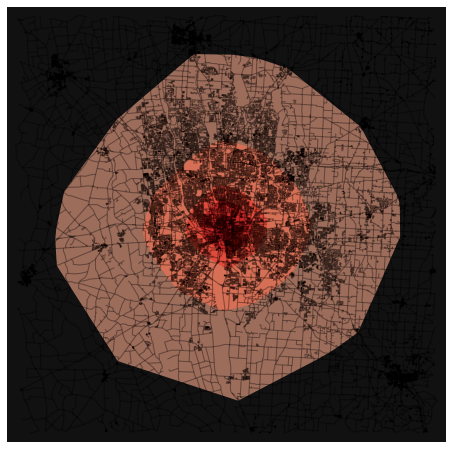

CPU times: user 43.8 s, sys: 301 ms, total: 44.1 s
Wall time: 43.6 s


In [25]:
%%time

# get one color for each isochrone
iso_colors = ox.plot.get_colors(n=len(trip_times), cmap='Reds', start=0.3, return_hex=True)

# plot the network then add isochrones as colored descartes polygon patches
fig, ax = ox.plot_graph(G, figsize=(8, 8), show=False, close=False, save=True, edge_color='k', edge_alpha=0.2, node_color='none')
for polygon, fc in zip(isochrone_polys, iso_colors):
    patch = PolygonPatch(polygon, fc=fc, ec='none', alpha=0.6, zorder=-1)
    ax.add_patch(patch)
plt.show()